# Plotting overturning circulation in ACCESS-OM3

This notebook uses the initial spinup simulation of ACCESS-OM3.

In [1]:
import intake
from dask.distributed import Client
import matplotlib.pyplot as plt
import cmocean as cm

In [2]:
client = Client(threads_per_worker=1)
print(client.dashboard_link)

/proxy/8787/status


## Load data from ESM datastore

In [3]:
datastore_path = "/g/data/ol01/access-om3-output/access-om3-025/MC_25km_jra_ryf-1.0-beta/experiment_datastore.json"

datastore = intake.open_esm_datastore(
    datastore_path,
    columns_with_iterables=[
        "variable",
        "variable_long_name",
        "variable_standard_name",
        "variable_cell_methods",
        "variable_units"
    ]
)

In [4]:
vmo = datastore.search(variable="vmo").to_dask(
    xarray_open_kwargs = dict(
        chunks={"time": -1},
        decode_timedelta=True
    )
)

## 10-year mean overturning streamfunction

In [5]:
psi = (
    vmo["vmo"]
    .sel(time=slice("1918-01-01", "1927-12-31"))
    .mean("time")
    .sum("xh")
    .cumsum("rho2_l")
    .load()
    / 1025
    / 1e6
)

Text(0.5, 1.0, 'Overturning in ACCESS-OM3')

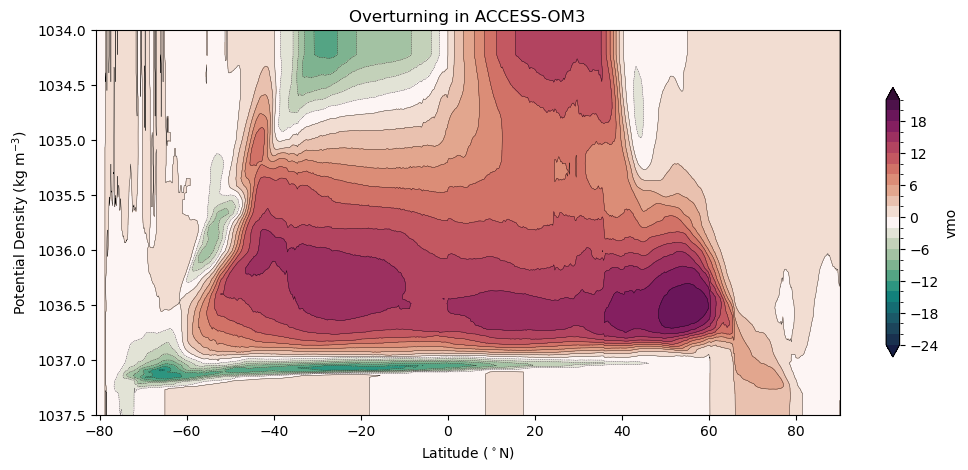

In [6]:
plt.figure(figsize=(12, 5))
levels = range(-24, 24, 2)
psi.plot.contourf(
    levels=levels, cmap=cm.cm.curl, extend="both", cbar_kwargs={"shrink": 0.7}
)
psi.plot.contour(levels=levels, colors="k", linewidths=0.25)
plt.gca().invert_yaxis()
plt.ylim((1037.5, 1034))
plt.ylabel("Potential Density (kg m$^{-3}$)")
plt.xlabel("Latitude ($^\circ$N)")
plt.title("Overturning in ACCESS-OM3")

## Timeseries of overturning at key latitudes

In [7]:
psi_time = vmo["vmo"].sum("xh").cumsum("rho2_l") / 1025 / 1e6
psi_30S = (
    psi_time.sel(yq=-30, method="nearest")
    .sel(rho2_l=slice(1035, 1038))
    .max(dim="rho2_l")
    .load()
)
psi_26N = (
    psi_time.sel(yq=26, method="nearest")
    .sel(rho2_l=slice(1035, 1038))
    .max(dim="rho2_l")
    .load()
)
psi_55N = (
    psi_time.sel(yq=5, method="nearest")
    .sel(rho2_l=slice(1035, 1038))
    .max(dim="rho2_l")
    .load()
)
psi_abyss = (
    -psi_time.sel(yq=-60, method="nearest")
    .sel(rho2_l=slice(1035, 1038))
    .min(dim="rho2_l")
    .load()
)

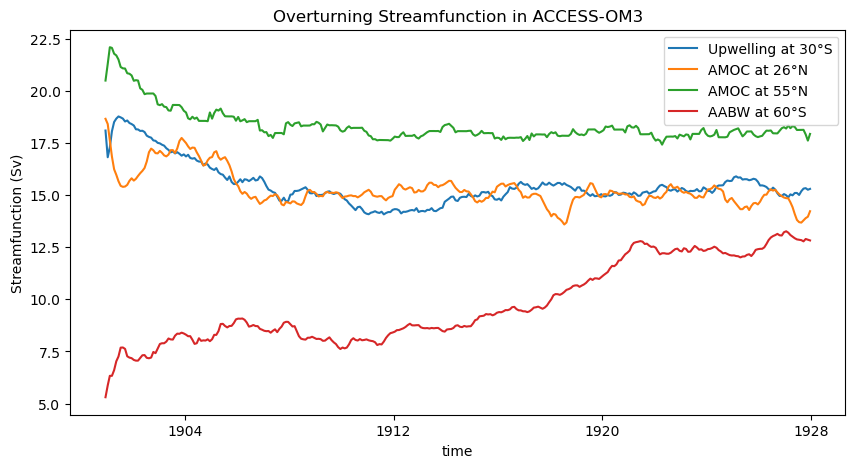

In [8]:
plt.figure(figsize=(10, 5)) 

psi_30S.rolling(time=12).mean().plot(label='Upwelling at 30°S')
psi_26N.rolling(time=12).mean().plot(label='AMOC at 26°N')
psi_55N.rolling(time=12).mean().plot(label='AMOC at 55°N')
psi_abyss.rolling(time=12).mean().plot(label='AABW at 60°S')

plt.ylabel('Streamfunction (Sv)')
plt.title('Overturning Streamfunction in ACCESS-OM3')
plt.legend()

In [9]:
client.close()